# Training a full model

This tutorial illustrates how to train a machine learning model for miniML. The model is a convolutional neural network (CNN) and long-short term memory (LSTM) network. The notebook illlustrates how to train a full model using training data of cerebellar GC miniature excitatory postsynaptic currents as described in the miniML manuscript. 

For details please refer to the manuscript in eLife and to the GitHub repository.

eLife: https://doi.org/10.7554/eLife.98485.1

GitHub: https://github.com/delvendahl/miniML

## Preparation

Labeled training data are available in the [Zenodo](https://doi.org/10.5281/zenodo.14507343) repository. Details on the dataset are described in the [miniML paper](https://doi.org/10.7554/eLife.98485.1). We begin by downloading the training dataset from Zenodo:

In [6]:
import requests

file_url = 'https://zenodo.org/records/14507343/files/1_GC_mepsc_train.h5'

response = requests.get(file_url)

if response.status_code == 200:
    with open('../_data/GC_mEPSC_training_data.h5', 'wb') as file:
        file.write(response.content)
    print('Downloaded GC_mEPSC_training_data.h5')

Downloaded GC_mEPSC_training_data.h5


Now we set up our Python environment:

In [7]:
import tensorflow as tf
from tensorflow.keras.layers import (Input, BatchNormalization, AveragePooling1D, Conv1D,
                                     Bidirectional, LSTM, Dense, Dropout, LeakyReLU)
from tensorflow.keras.optimizers.legacy import Adam
from sklearn.preprocessing import minmax_scale
from sklearn.model_selection import train_test_split
from sklearn.metrics import auc, confusion_matrix, ConfusionMatrixDisplay, roc_curve, matthews_corrcoef
import time
import h5py
import numpy as np
import matplotlib.pyplot as plt

print('Using TF version', tf.__version__)
print('GPUs available:', len(tf.config.list_physical_devices('GPU')))

Using TF version 2.15.0
GPUs available: 1


## Set hyperparameters for training

The following parameters are used for training the model:

In [8]:
settings = {
    'training_size': 0.8,
    'testing_size': None,
    'learn_rate': 2e-5,
    'epsilon': 1e-8,
    'patience': 8,
    'epochs': 100,
    'batch_size': 128,
    'dropout': 0.2,
    'training_data': '../_data/GC_mEPSC_training_data.h5'
}

## Load training data

Now we can load the training data. The data is stored in an HDF5 file containing about 30,000 data segments with 600 time points each. Each data segment has a label of 0 (negative) or 1 (positive).

We min-max scale the data and split the dataset into training and test sets. The training set is used to train the model, while the test set is used to evaluate the model. Both sets are `tf.data.Dataset` objects.

In [9]:
with h5py.File(f'{settings["training_data"]}', 'r') as f:
    x = f['events'][:]
    y = f['scores'][:]

print(f'loaded events with shape {x.shape}')
print(f'loaded scores with shape {y.shape}') 
print(f'ratio of pos/neg scores: {y.sum()/(y.shape[0]-y.sum()):.2f}')

scaled_data = minmax_scale(x, feature_range=(0,1), axis=1)
scaled_data = np.expand_dims(scaled_data, axis=2)
y = np.expand_dims(y, axis=1)
x_train, x_test, y_train, y_test = train_test_split(scaled_data, y, train_size=settings['training_size'], random_state=1234)

train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train))
test_dataset = tf.data.Dataset.from_tensor_slices((x_test, y_test))

loaded events with shape (30140, 600)
loaded scores with shape (30140,)
ratio of pos/neg scores: 1.03


## Build the model

Here, we define our model architecture. The model is a convolutional neural network (CNN) and long-short term memory (LSTM) network.

In [10]:
def build_model(x_train, dropout_rate):
    model = tf.keras.models.Sequential()
    model.add(Input(shape=(x_train.shape[1:])))
              
    model.add(Conv1D(filters=32, kernel_size=9, padding='same'))
    model.add(BatchNormalization())
    model.add(LeakyReLU())
    model.add(AveragePooling1D(pool_size=3, strides=3))
    
    model.add(Conv1D(filters=48, kernel_size=7, padding='same'))
    model.add(BatchNormalization())
    model.add(LeakyReLU())
    model.add(AveragePooling1D(pool_size=2, strides=2))
    
    model.add(Conv1D(filters=64, kernel_size=5, padding='same'))
    model.add(BatchNormalization())
    model.add(LeakyReLU())
    model.add(AveragePooling1D(pool_size=2, strides=2))
    
    model.add(Conv1D(filters=80, kernel_size=3, padding='same'))
    model.add(BatchNormalization())
    model.add(LeakyReLU())
    
    model.add(Bidirectional(LSTM(96, dropout=dropout_rate), merge_mode='sum'))
    model.add(Dense(128, activation=LeakyReLU()))
    model.add(Dropout(dropout_rate))
    model.add(Dense(1, activation='sigmoid'))
    
    return model


model = build_model(x_train, settings['dropout'])
model.compile(optimizer=Adam(learning_rate=settings['learn_rate'], epsilon=settings['epsilon'], amsgrad=True),
              loss=tf.keras.losses.BinaryCrossentropy(), 
              metrics=['Accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 600, 32)           320       
                                                                 
 batch_normalization (Batch  (None, 600, 32)           128       
 Normalization)                                                  
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 600, 32)           0         
                                                                 
 average_pooling1d (Average  (None, 200, 32)           0         
 Pooling1D)                                                      
                                                                 
 conv1d_1 (Conv1D)           (None, 200, 48)           10800     
                                                                 
 batch_normalization_1 (Bat  (None, 200, 48)           1

## Train the model

Now we can train our model using the training data. Note that running this cell can take a few minutes on a GPU. When using the CPU, the training time can be much longer. 

We also provide an executable notebook for model training on Kaggle, which is available [here](https://www.kaggle.com/code/philipponeill/miniml-full-training).

In [11]:
early_stopping_callback = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', 
    patience=settings['patience'],
    restore_best_weights=True)

start = time.time()
SHUFFLE_BUFFER_SIZE = 100

train_dataset = train_dataset.shuffle(SHUFFLE_BUFFER_SIZE).batch(settings['batch_size'], num_parallel_calls=tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(settings['batch_size'], num_parallel_calls=tf.data.AUTOTUNE)

train_dataset = train_dataset.prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.prefetch(tf.data.AUTOTUNE)

history = model.fit(train_dataset,
                    verbose=2,
                    epochs=settings['epochs'],
                    validation_data=test_dataset,
                    shuffle=True,
                    callbacks=[early_stopping_callback])

print('')
print('----')
print(f'train shape: {x_train.shape}')
print(f'score on val: {model.evaluate(test_dataset, verbose=0)[1]}')
print(f'score on train: {model.evaluate(train_dataset, verbose=0)[1]}')
print('----')
print(f'training time (s): {time.time()-start:.4f}')

Epoch 1/100


2025-01-08 20:15:44.674941: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


189/189 - 12s - loss: 0.4509 - Accuracy: 0.8208 - val_loss: 0.6007 - val_Accuracy: 0.7918 - 12s/epoch - 61ms/step
Epoch 2/100
189/189 - 7s - loss: 0.3724 - Accuracy: 0.8393 - val_loss: 0.5336 - val_Accuracy: 0.7502 - 7s/epoch - 38ms/step
Epoch 3/100
189/189 - 7s - loss: 0.3158 - Accuracy: 0.8619 - val_loss: 0.4187 - val_Accuracy: 0.8183 - 7s/epoch - 38ms/step
Epoch 4/100
189/189 - 7s - loss: 0.1660 - Accuracy: 0.9411 - val_loss: 0.1617 - val_Accuracy: 0.9423 - 7s/epoch - 39ms/step
Epoch 5/100
189/189 - 8s - loss: 0.1171 - Accuracy: 0.9560 - val_loss: 0.0961 - val_Accuracy: 0.9645 - 8s/epoch - 40ms/step
Epoch 6/100
189/189 - 7s - loss: 0.1020 - Accuracy: 0.9611 - val_loss: 0.0917 - val_Accuracy: 0.9678 - 7s/epoch - 37ms/step
Epoch 7/100
189/189 - 7s - loss: 0.0970 - Accuracy: 0.9636 - val_loss: 0.0848 - val_Accuracy: 0.9693 - 7s/epoch - 37ms/step
Epoch 8/100
189/189 - 7s - loss: 0.0909 - Accuracy: 0.9659 - val_loss: 0.0813 - val_Accuracy: 0.9695 - 7s/epoch - 37ms/step
Epoch 9/100
189/18

## Plot training and evaluate the model

We can plot the training and validation accuracy and loss to visualize the training progress.

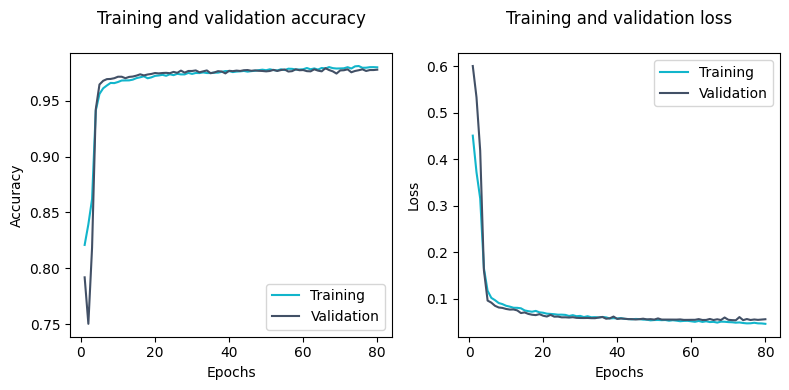

Best epoch: 66 (accuracy=0.9791)


In [12]:
acc = history.history['Accuracy']
val_acc = history.history['val_Accuracy']
epochs = range(1, len(acc) + 1)

fig, axs = plt.subplots(1, 2, figsize=(8, 4))
axs[0].plot(epochs, acc, '#12B5CB', label='Training')
axs[0].plot(epochs, val_acc, '#425066', label='Validation')
axs[0].set_title('Training and validation accuracy\n')
axs[0].set_xlabel('Epochs')
axs[0].set_ylabel('Accuracy')
axs[0].legend()

loss = history.history['loss']
val_loss = history.history['val_loss']

axs[1].plot(epochs, loss, '#12B5CB', label='Training')
axs[1].plot(epochs, val_loss, '#425066', label='Validation')
axs[1].set_title('Training and validation loss\n')
axs[1].set_xlabel('Epochs')
axs[1].set_ylabel('Loss')
axs[1].legend()
plt.tight_layout()
plt.show()

best_epoch = val_acc.index(max(val_acc)) + 1
print(f'Best epoch: {best_epoch} (accuracy={max(val_acc):.4f})')

We can plot the ROC curve and the confusion matrix to further evaluate our trained model.

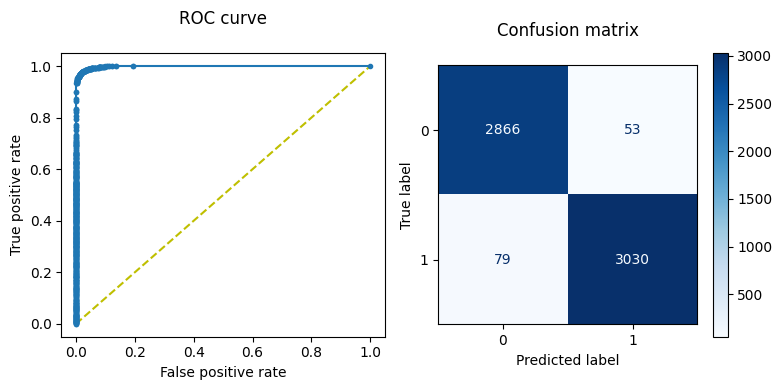

Area under curve, AUC = 0.9982669197087304
Optimal threshold value = 0.5512554049491882
Matthews correlation coefficient = 0.956173924031956


In [13]:
y_preds = model.predict(x_test, verbose=0).ravel()
fpr, tpr, thresholds = roc_curve(y_test, y_preds)

fig, axs = plt.subplots(1, 2, figsize=(8, 4))
axs[0].plot([0, 1], [0, 1], 'y--')
axs[0].plot(fpr, tpr, marker='.')
axs[0].set_xlabel('False positive rate')
axs[0].set_ylabel('True positive rate')
axs[0].set_title('ROC curve\n')

optimal_threshold = thresholds[np.argmax(tpr - fpr)]
y_pred2 = (model.predict(x_test, verbose=0) >= optimal_threshold).astype(int)
cm = confusion_matrix(y_test, y_pred2)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Blues', ax=axs[1])
axs[1].set_title('Confusion matrix\n')
plt.tight_layout()
plt.show()

print(f'Area under curve, AUC = {auc(fpr, tpr)}')
print(f'Optimal threshold value = {optimal_threshold}')
print(f'Matthews correlation coefficient = {matthews_corrcoef(y_test, y_preds>0.5)}')

## Save trained model and training settings

Finally, we save the trained model to an .h5 file and the training settings to a text file.

In [14]:
model.save('../results/lstm_full_training.h5')

with open('../results/full_training_settings.txt', 'w') as text_file:
    text_file.write('\n'.join(f'{i}: {settings[i]}' for i in settings))

/opt/miniconda3/envs/miniml/lib/python3.9/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
